In [19]:
%matplotlib inline
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Simple test implementation of SIREN

In [3]:
data = torch.randint(0, 10, (5,4,3,2)).cuda()

def ndidx(t):
    '''
    Return a tensor of n-dimensional
    indices for the provided tensor.
    '''
    all_idx = []
    idx = torch.arange(t.numel())
    for size in t.shape[::-1]:
        all_idx.append(torch.remainder(idx, size))
        idx = torch.div(idx, size, rounding_mode='floor')
    return torch.stack(all_idx[::-1], dim=1)

def test_ndidx(t):
    idx = ndidx(t)
    flat_t = t.flatten()
    assert len(idx) == len(flat_t)
    for i, v in zip(idx, flat_t):
        assert v == t[tuple(i)]
        
def imshow(im):
    plt.imshow(im, vmin=0, vmax=1, cmap='gray')

test_ndidx(data)

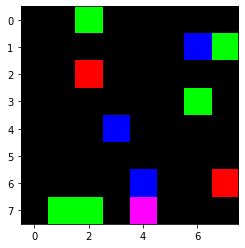

In [167]:
# create random image
data = torch.zeros(8, 8, 3)
data.bernoulli_(p=0.1)
imshow(data)

In [168]:
# convert image to pixel indices and intensity values
X = ndidx(data[...,0]).float().cuda()
Y = data.reshape(-1, data.shape[-1]).float().cuda()

# get means for centering the data
X_mean = X.mean(dim=0, keepdims=True)
Y_mean = Y.mean(dim=0, keepdims=True)

X.shape, Y.shape

(torch.Size([64, 2]), torch.Size([64, 3]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


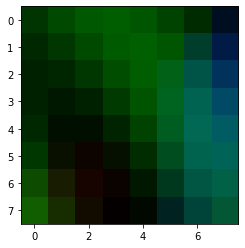

In [169]:
# create a very simple neural network with sine activations

class Sine(nn.Module):
    '''
    A sinusoidal activation function.
    '''
    def forward(self, x):
        return torch.sin(x)

n_hidden = 10
activ_fn = Sine

model = nn.Sequential(
    nn.Linear(X.shape[1], n_hidden), activ_fn(),
    nn.Linear(n_hidden, n_hidden), activ_fn(),
    nn.Linear(n_hidden, Y.shape[1])
).cuda()

# generate an image using the initial model parameters
Y_pred = model(X - X_mean)
pred = (Y_pred + Y_mean).reshape(data.shape).detach().cpu().numpy()
imshow(pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


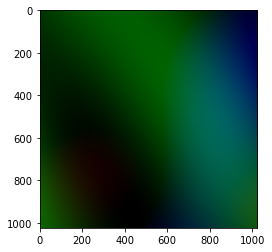

In [170]:
# super resolution
super_res = (1024, 1024)
X_super = (
    ndidx(torch.zeros(*super_res)).float() *
    torch.tensor(data.shape)[:-1].unsqueeze(0) /
    torch.tensor(super_res).unsqueeze(0)
).cuda()

Y_super = model.forward(X_super - X_mean) + Y_mean
pred = Y_super.reshape(super_res + (data.shape[-1],)).detach().cpu().numpy()
imshow(pred)

In [171]:
# fit the SIREN model to the real image
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def pde_loss(y, x):
    dydx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
    d2ydx2 = torch.autograd.grad(dydx, x, grad_outputs=torch.ones_like(dydx), create_graph=True)[0]
    pde = d2ydx2.sum(dim=1) + y.sum(dim=1)
    return (pde**2).mean()

X.requires_grad = True

n_steps = 10000
for i in range(n_steps+1):
    Y_pred = model.forward(X - X_mean)
    loss = F.mse_loss(Y - Y_mean, Y_pred) + pde_loss(Y_pred, X)
    if i % 1000 == 0:
        print(f'step = {i}, loss = {loss}')
    if i == n_steps:
        break
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


step = 0, loss = 0.27717524766921997
step = 1000, loss = 0.04359123110771179
step = 2000, loss = 0.0379161611199379
step = 3000, loss = 0.028688907623291016
step = 4000, loss = 0.021519530564546585
step = 5000, loss = 0.017377328127622604
step = 6000, loss = 0.015774723142385483
step = 7000, loss = 0.01523736584931612
step = 8000, loss = 0.01494340505450964
step = 9000, loss = 0.01466258242726326
step = 10000, loss = 0.01447237003594637


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.4275797, 0.86716545)

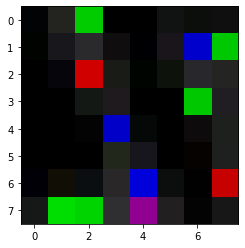

In [172]:
# generate an image using the trained SIREN model
Y_pred = model.forward(X - X_mean) + Y_mean
pred = Y_pred.reshape(data.shape).detach().cpu().numpy()
imshow(pred)
(pred.min(), pred.max())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


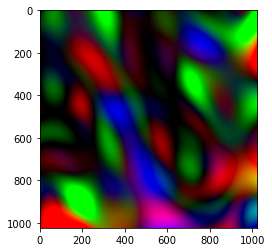

In [173]:
# super resolution
super_res = (1024, 1024)
X_super = (
    ndidx(torch.zeros(*super_res)).float() *
    torch.tensor(data.shape)[:-1].unsqueeze(0) /
    torch.tensor(super_res).unsqueeze(0)
).cuda()

Y_super = model.forward(X_super - X_mean) + Y_mean
pred = Y_super.reshape(super_res + (data.shape[-1],)).detach().cpu().numpy()
imshow(pred)

In [165]:
# compare image sizes with model size
n_params = 0
for p in model.parameters():
    n_params += p.numel()
data.numel(), n_params, pred.size

(192, 173, 3145728)